In [1]:
import pandas as pd
import openml
import data_preprocess as dp

data_name = 'porto-seguro'

data = openml.datasets.get_dataset(42206)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

# Data Preprocessing

In [2]:
from copy import deepcopy

categorical = [b for a, b in zip(categorical_indicator, attribute_names) if a]
numerical = [b for a, b in zip(categorical_indicator, attribute_names) if not a]

encoded_data = deepcopy(X)

for col in categorical:
    
    mapping = {c: i+1 for i, c in enumerate(encoded_data[col].unique())}
    encoded_data[col] = encoded_data[col].replace(mapping)

encoded_data = encoded_data[numerical + categorical]
encoded_data.fillna(0, inplace=True)
encoded_data

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,2,5,0,11,0.7,0.2,0.718070,2.0,0.400000,0.883679,...,1,1,1,1,1,1,1,1,1,1
1,1,7,0,3,0.8,0.4,0.766078,3.0,0.316228,0.618817,...,1,1,1,2,2,1,2,2,1,2
2,5,9,0,12,0.0,0.0,0.000000,1.0,0.316228,0.641586,...,1,1,1,2,3,1,2,2,1,3
3,0,2,0,8,0.9,0.2,0.580948,1.0,0.374166,0.542949,...,1,2,1,1,2,1,2,3,1,4
4,0,0,0,9,0.7,0.6,0.840759,3.0,0.316070,0.565832,...,1,1,1,2,3,1,2,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,3,10,0,13,0.5,0.3,0.692820,3.0,0.374166,0.684631,...,1,1,1,1,9,1,2,1,1,37
595208,5,3,0,6,0.9,0.7,1.382027,2.0,0.387298,0.972145,...,1,1,1,2,6,3,1,2,1,85
595209,1,10,0,12,0.9,0.2,0.659071,3.0,0.397492,0.596373,...,1,1,1,2,9,1,2,2,1,37
595210,5,3,0,12,0.9,0.4,0.698212,3.0,0.374166,0.764434,...,1,1,1,2,2,1,2,2,1,11


In [3]:
mapping = {b: int(i) for i, b in enumerate(y.unique())}


y = y.replace(mapping)
y

0         0
1         0
2         0
3         0
4         0
         ..
595207    0
595208    0
595209    0
595210    0
595211    0
Name: target, Length: 595212, dtype: int64

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data, left_out, train_label, y_left_out = train_test_split(encoded_data, y, test_size=0.05, random_state=42)
test_data, dev_data, test_label, dev_label = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {train_data.shape}\n test shape: {test_data.shape}\n dev shape: {dev_data.shape}')

train shape: (565451, 37)
 test shape: (14880, 37)
 dev shape: (14881, 37)


In [5]:
from copy import deepcopy

r_train_data = deepcopy(train_data)

In [6]:
from sklearn.preprocessing import Normalizer, StandardScaler

nn = StandardScaler()

nn.fit(train_data[numerical])

train_data[numerical] = nn.transform(train_data[numerical])
dev_data[numerical] = nn.transform(dev_data[numerical])
test_data[numerical] = nn.transform(test_data[numerical])

# Build graph

In [8]:
adj_matrix, index_to_name, name_to_index = dp.compute_adjacency_matrix(data=r_train_data, 
                                                                       self_loop_weight=20, categorical=categorical)

In [9]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_data, train_label)

In [10]:
train = dp.transform_to_tensors(X_over, y_over, adj_matrix)

test = dp.transform_to_tensors(test_data, test_label, adj_matrix)

dev = dp.transform_to_tensors(dev_data, dev_label, adj_matrix)


torch.Size([1089756, 37, 1])
torch.Size([1089756])
torch.Size([14880, 37, 1])
torch.Size([14880])
torch.Size([14881, 37, 1])
torch.Size([14881])


In [11]:
from torch.utils.data import DataLoader
import torch

batch_size = 64

train_dataset = dp.Data(data=train)
val_dataset = dp.Data(data=dev)
test_dataset = dp.Data(data=test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Train IGNH

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
import torch
from ignh import train_model


gnn_model = train_model(adj_matrix=adj_matrix, 
            index_to_name=index_to_name,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            data_name=data_name,
            num_classes=1,
            dataframe=encoded_data, 
            categorical=categorical, 
            numerical=numerical,
            gnn_model=None, 
            optimizer_train=None, 
            current_epoch=1,
            num_epochs=20,
            learning_rate=1e-03,
            normalize_adj=False)


## Evaluate the trained model on the test set

In [13]:
import torch.nn as nn
from ignh import IGNH
from tqdm import tqdm



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1 
adj_matrix = torch.FloatTensor(adj_matrix)

gnn_model = IGNH(adj_matrix[0].shape[0], adj_matrix.to(device), 1, index_to_name, dataframe=encoded_data, 
            categorical=categorical, 
            numerical=numerical,).to(device)

torch.cuda.empty_cache()

gnn_model.load_state_dict(torch.load(f'{data_name}/m.model'))

print('*** Testing : ****')
gnn_model.eval()

correct = 0
count = 0
count_2 = 0

list_prediction = []
list_pob_pred = []
y_test = []

for i, data in tqdm(list(enumerate(test_dataloader))):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = gnn_model(inputs)
    list_pob_pred.extend(outputs.tolist())

    preds = (outputs.reshape(-1) > 0.5) * 1

    list_prediction.extend(preds.tolist())

    count+= torch.sum(preds == labels.data)

    for i in range(len(preds)):
        if preds[i] == labels[i] == 1:
            count_2 += 1

    y_test.extend(labels.tolist())

    torch.cuda.empty_cache()


roc = roc_auc_score(y_test, list_pob_pred)
prec = precision_score(y_test, list_prediction, average='macro')
recall = recall_score(y_test, list_prediction, average='macro')
f_score = f1_score(y_test, list_prediction, average='macro')

print('AUC is : {},  prec {},  recall {}, f-score {}' .format(roc, prec, recall, f_score))

  0%|                                                                                          | 0/233 [00:00<?, ?it/s]

*** Testing : ****


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:05<00:00, 42.34it/s]


AUC is : 0.6325369881268869,  prec 0.5148380084114318,  recall 0.598587514449658, f-score 0.4324351657001297


# Explain one example

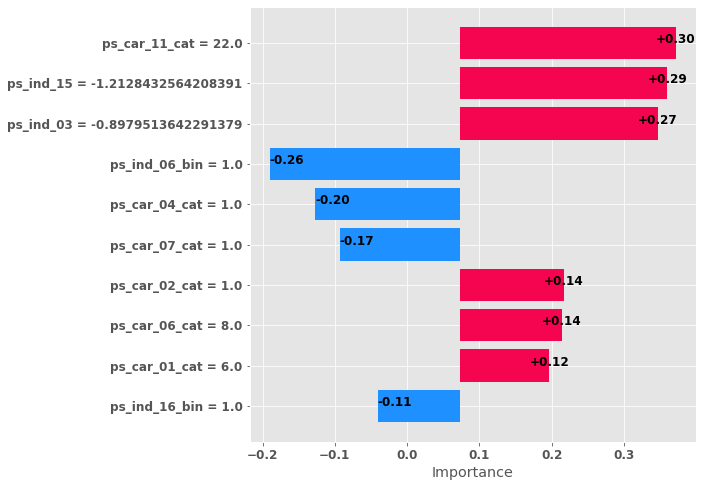

tensor([[0.6113]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [15]:
#num of features to use
top_n = 10

gnn_model.plot_bars(test[10][0].reshape(1, adj_matrix.shape[0], 1).to(device), test_data.iloc[0], top_n)
gnn_model.predict(test[10][0].reshape(1, adj_matrix.shape[0], 1).to(device))

# Interpretability Evaluation

In [16]:
importances = gnn_model.weights.cpu().detach().reshape(-1).numpy()

feature_global_importance = {}
for i, v in enumerate(importances):
    feature_global_importance[index_to_name[i]] = v

In [17]:
'''function to obtain feature scores from IGNNet model'''

def get_local_values(example, feature_global_importance, adj_matrix, index_to_name):
    array_to_use = np.array(example)    
    array = torch.FloatTensor(array_to_use).reshape(1, adj_matrix.shape[0], 1)
    local_importance = gnn_model.get_local_importance(array.to(device))[-1]

    names = []
    values = []
    for i, v in enumerate(local_importance):
        name = index_to_name[i]
        names.append(name)
        values.append(feature_global_importance[name]*v)
    return names, values

In [18]:
from sklearn.preprocessing import StandardScaler
from data_preprocess import BlackBoxWrapper


num_features = adj_matrix.shape[0]


bb = BlackBoxWrapper(gnn_model, num_features, device)

def black_box(x, S):
    pred = bb(x, S)
    return pred.cpu().data.numpy()

In [19]:
'''
Evaluate a black-box model.
  x: input examples.
  S: coalitions.
'''

x = test_dataset[0][0]
x = x.reshape((1,x.shape[0])).numpy()

'''compute the feature scores on a vector of all features masked'''
S = np.zeros_like(x)
_, null =  get_local_values(S, feature_global_importance, adj_matrix, index_to_name)

## Explain 500 examples and compare KernelSHAP to IGNNet after each iteration of data sampling

In [20]:
from tqdm import tqdm
import shapreg
import pickle
import os.path
from numpy.linalg import norm
from scipy.stats import spearmanr
import copy

if os.path.isfile(f'{data_name}_exp.pickle'):
    print('Loading saved explanations')

    with open(f'{data_name}_exp.pickle', 'rb') as file:
        all_instance_results_loaded = pickle.load(file)
        
    all_l2_distances = []
    all_cos_sim = []
    all_spearman_c = []

    for x, all_results in tqdm(all_instance_results_loaded):

        _, true_values = get_local_values(x, feature_global_importance, adj_matrix, index_to_name)
        
        instance_l2_dis = []
        instance_cos_sim = []
        spearman_c = []
        
        '''the Shapley values for an input x sum to the difference p(y=1 | x) - p(y=1)'''
        true_values = np.array(true_values) - null

        for i in list(all_results['iters']):

            knl_shp = all_results['values'][list(all_results['iters']).index(i)].reshape(-1)

            instance_l2_dis.append(norm(true_values - knl_shp))
            instance_cos_sim.append(np.dot(true_values, knl_shp)/(norm(true_values)*norm(knl_shp)))
            coef, p = spearmanr(true_values, knl_shp)
            spearman_c.append(coef)
            
        all_l2_distances.append(instance_l2_dis)
        all_cos_sim.append(instance_cos_sim)
        all_spearman_c.append(spearman_c)

else:
    
    all_l2_distances = []
    all_cos_sim = []
    all_instance_results = []
    all_spearman_c = []

    count = 1
    for x_, _ in tqdm(test_dataset):
        _, true_values = get_local_values(x_, feature_global_importance, adj_matrix, index_to_name)

        x = x_.reshape((1,x_.shape[0])).numpy()

        # Run KernelSHAP to convergence
        game_ = shapreg.games.PredictionGame(black_box, x)
        try:
            '''more examples are available here'''
            shap_values, all_results = shapreg.shapley.ShapleyRegression(
                game_, batch_size=16, n_samples=2000, paired_sampling=True, detect_convergence=False,
                bar=False, return_all=True)
        except:
            continue

        instance_l2_dis = []
        instance_cos_sim = []
        spearman_c = []

        true_values = np.array(true_values) - null

        for i in list(all_results['iters']):

            knl_shp = all_results['values'][list(all_results['iters']).index(i)].reshape(-1)

            instance_l2_dis.append(norm(true_values - knl_shp))
            instance_cos_sim.append(np.dot(true_values, knl_shp)/(norm(true_values)*norm(knl_shp)))
            coef, p = spearmanr(true_values, knl_shp)
            spearman_c.append(coef)
            
        all_l2_distances.append(instance_l2_dis)
        all_cos_sim.append(instance_cos_sim)
        all_spearman_c.append(spearman_c)

        all_instance_results.append((copy.deepcopy(x_), copy.deepcopy(all_results)))
        
        count += 1
        if count > 500:
            break
    print('saving explanations')

    with open(f'{data_name}_exp.pickle', 'wb') as file:
        pickle.dump(all_instance_results, file)


Loading saved explanations


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.61it/s]


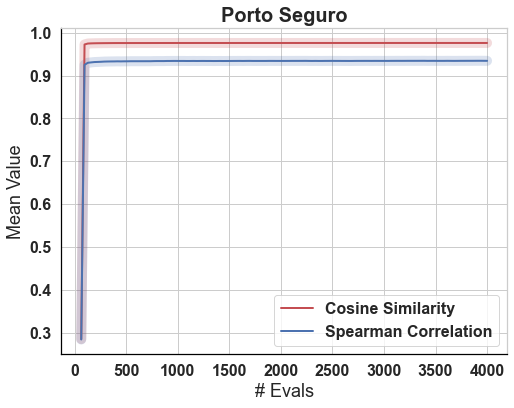

In [21]:


'''Plot the computed similarity scores'''

mean_cos_sim = np.mean(all_cos_sim, axis=0)
mean_spearman_c = np.mean(all_spearman_c, axis=0)

import matplotlib.pyplot as plt  
# Plot the line graph
import seaborn as sb
sb.set(rc={'figure.figsize':(8,6)})
sb.set_theme(style='whitegrid')

plt.plot(all_results['iters'], mean_cos_sim, "r-", linewidth=10, alpha=0.2)
plt.plot(all_results['iters'], mean_spearman_c, "b-", linewidth=10, alpha=0.2)

plt.plot(all_results['iters'], mean_cos_sim, "r-", label='Cosine Similarity', linewidth=2)
plt.plot(all_results['iters'], mean_spearman_c, "b-", label='Spearman Correlation', linewidth=2)

# Add labels and title
plt.xlabel('# Evals', fontsize=18)
plt.ylabel('Mean Value', fontsize=18)
plt.title(f'Porto Seguro', fontsize=20, fontweight='bold')
plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax = plt.gca()

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Display the graph
plt.show()